In [1]:
import numpy as np
import pandas as pd
import wfdb
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch
from scipy.stats import skew, kurtosis
import WTdelineator as wav  #this file take from the git hub 

In [3]:
# Load 500 Hz high-resolution ECG from PTB-XL
data_folder = "Dataset/ptbxl"
record_path = data_folder + "/records500/00000/00001_hr"

signal, fields = wfdb.rdsamp(record_path)
fs = 500  # update sampling frequency
lead_sig = signal[:, 1]  # use lead II

# Run delineation on raw 500 Hz signal
Pwav, QRS, Twav = wav.signalDelineation(lead_sig, fs)
P_on, P_off = Pwav[:, 0], Pwav[:, 3]
Q_on, S_off = QRS[:, 0], QRS[:, 4]
R_pk = QRS[:, 2]
T_on, T_off = Twav[:, 0], Twav[:, 3]

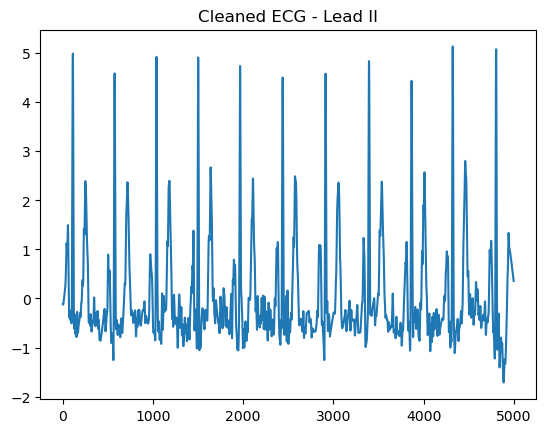

In [4]:


# Define a bandpass filter function to keep frequencies between 0.5 and 40 Hz (removes noise and baseline wander)
def bandpass_filter(sig, fs=100, low=0.5, high=40):
    # Calculate Nyquist frequency (half of the sampling frequency)
    nyq = 0.5 * fs
    # Design a 4th-order Butterworth bandpass filter
    b, a = butter(4, [low / nyq, high / nyq], btype="band")
    # Apply the filter using zero-phase filtering (filtfilt avoids phase shift)
    return filtfilt(b, a, sig)

# Preprocessing function for ECG signal
def preprocess(sig, fs=100):
    # Apply bandpass filter to remove noise and drift
    f = bandpass_filter(sig, fs)
    # Remove the median to reduce baseline
    f -= np.median(f)
    # Normalize the signal to have zero mean and unit variance
    return (f - np.mean(f)) / np.std(f)

# Preprocess the ECG signal from a single lead (e.g., Lead II)
ecg_cleaned = preprocess(lead_sig, fs)

# Plot the cleaned ECG signal
plt.plot(ecg_cleaned)
# Set the title of the plot
plt.title("Cleaned ECG - Lead II")
# Display the plot
plt.show()


#  This part processes and visualizes ECG wave delineation points (P, QRS, T) using cleaned signal indices.

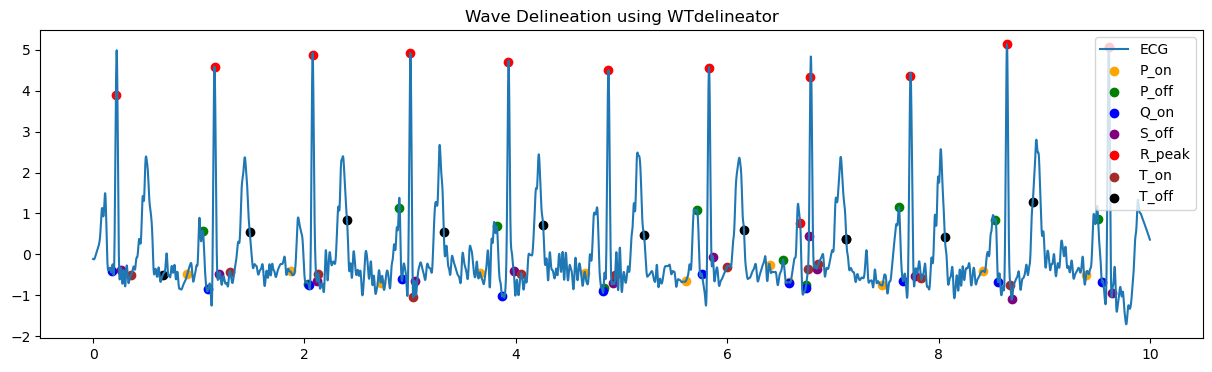

Valid P_on points: 11
Valid Q_on points: 12
Valid R_peaks: 12


In [6]:
# Define a function to clean the detected indices
def clean_indices(indices, length):
    """Convert to int and keep only valid indices within signal length."""
    # Convert indices to integers and keep only those within valid signal range
    return np.array([int(i) for i in indices if i > 0 and i < length], dtype=int)

# Clean and validate all delineated wave indices (to ensure they are within ECG signal length)
P_on_idx  = clean_indices(P_on, len(ecg_cleaned))      # P wave onset points
P_off_idx = clean_indices(P_off, len(ecg_cleaned))     # P wave offset points
Q_on_idx  = clean_indices(Q_on, len(ecg_cleaned))      # Q wave onset points
S_off_idx = clean_indices(S_off, len(ecg_cleaned))     # S wave offset points
R_pk_idx  = clean_indices(R_pk, len(ecg_cleaned))      # R peak points
T_on_idx  = clean_indices(T_on, len(ecg_cleaned))      # T wave onset points
T_off_idx = clean_indices(T_off, len(ecg_cleaned))     # T wave offset points

# Create a time axis for plotting (based on sampling frequency)
t = np.arange(len(ecg_cleaned)) / fs

# Set up the plot
plt.figure(figsize=(15, 4))                       # Define figure size
plt.plot(t, ecg_cleaned, label="ECG")             # Plot the cleaned ECG signal

# Mark the different wave points with scatter plots and colors
plt.scatter(t[P_on_idx], ecg_cleaned[P_on_idx], c="orange", label="P_on")     # P wave onset
plt.scatter(t[P_off_idx], ecg_cleaned[P_off_idx], c="green", label="P_off")   # P wave offset
plt.scatter(t[Q_on_idx], ecg_cleaned[Q_on_idx], c="blue", label="Q_on")       # Q wave onset
plt.scatter(t[S_off_idx], ecg_cleaned[S_off_idx], c="purple", label="S_off")  # S wave offset
plt.scatter(t[R_pk_idx], ecg_cleaned[R_pk_idx], c="red", label="R_peak")      # R peaks
plt.scatter(t[T_on_idx], ecg_cleaned[T_on_idx], c="brown", label="T_on")      # T wave onset
plt.scatter(t[T_off_idx], ecg_cleaned[T_off_idx], c="black", label="T_off")   # T wave offset

# Add legend and title
plt.legend()
plt.title("Wave Delineation using WTdelineator")
plt.show()  # Display the plot

# Print number of valid detected points for verification
print("Valid P_on points:", len(P_on_idx))
print("Valid Q_on points:", len(Q_on_idx))
print("Valid R_peaks:", len(R_pk_idx))


# This section extracts time-domain, frequency-domain, morphological, and statistical features from the delineated ECG signal for further analysis or classification.

In [ ]:
# ------------------- Feature Extraction -------------------

# Compute area under the curve between two indices using trapezoidal rule
def compute_area(signal, start_idx, end_idx):
    return np.trapz(np.abs(signal[start_idx:end_idx])) if end_idx > start_idx else np.nan

# Compute the slope (rate of change) between two signal points
def compute_slope(signal, idx1, idx2):
    return (signal[idx2] - signal[idx1]) / (idx2 - idx1) if idx2 > idx1 else np.nan

# Measure ST elevation at the J-point (0.08s after S wave offset)
def measure_st_elevation(signal, j_point, fs=100):
    idx = int(j_point + 0.08 * fs)
    baseline = np.mean(signal[: int(0.2 * fs)])  # Use first 0.2s as baseline
    return signal[idx] - baseline if idx < len(signal) else np.nan

# Count number of zero crossings in the signal
def zero_crossings(signal):
    return ((signal[:-1] * signal[1:]) < 0).sum()

# Dictionary to hold extracted features
features = {}

# RR interval features (heart rate variability)
rr = np.diff(R_pk) / fs * 1000  # Convert to milliseconds
features["RR_mean"] = np.nanmean(rr)              # Average RR interval
features["RR_std"] = np.nanstd(rr)                # RR interval standard deviation
features["HR"] = 60000 / features["RR_mean"] if features["RR_mean"] else np.nan  # Heart rate (bpm)

# Time-domain intervals (in milliseconds)
features["QRS_duration"] = np.nanmean([(s - q) / fs * 1000 for q, s in zip(Q_on, S_off) if s > q])
features["PR_interval"] = np.nanmean([(q - p) / fs * 1000 for p, q in zip(P_on, Q_on) if q > p])
features["QT_interval"] = np.nanmean([(t - q) / fs * 1000 for q, t in zip(Q_on, T_off) if t > q])
features["T_duration"] = np.nanmean([(tf - to) / fs * 1000 for to, tf in zip(T_on, T_off) if tf > to])

# Amplitude features
features["R_amp"] = np.nanmax(ecg_cleaned)                              # Maximum R peak amplitude
features["S_amp"] = np.nanmin(ecg_cleaned)                              # Minimum S point amplitude
features["R_S_ratio"] = features["R_amp"] / abs(features["S_amp"])      # R-to-S amplitude ratio
features["Q_amp"] = np.nanmean([ecg_cleaned[q] for q in Q_on if q < len(ecg_cleaned)])  # Q wave amplitude
features["QRS_area"] = np.nanmean([compute_area(ecg_cleaned, q, s) for q, s in zip(Q_on, S_off) if s > q])  # Area of QRS complex
features["T_amp"] = np.nanmean([ecg_cleaned[t] for t in Twav[:, 1] if t < len(ecg_cleaned)])  # T wave amplitude

# T wave asymmetry (slope ratio between rising and falling edge)
tasym = []
for to, tf in zip(T_on, T_off):
    if tf > to:
        mid = (to + tf) // 2
        su, sd = compute_slope(ecg_cleaned, to, mid), compute_slope(ecg_cleaned, mid, tf)
        if sd != 0:
            tasym.append(su / abs(sd))
features["T_asymmetry"] = np.nanmean(tasym) if tasym else np.nan

# ST elevation measurement
features["ST_elevation"] = np.nanmean([measure_st_elevation(ecg_cleaned, j) for j in S_off])

# Frequency domain features using Welch power spectral density
f, Pxx = welch(ecg_cleaned, fs, nperseg=1024)
bands = {"VLF": (0, 0.5), "LF": (0.5, 4), "MF": (4, 15), "HF": (15, 40)}
for b, (lo, hi) in bands.items():
    features[f"{b}_power"] = np.trapz(Pxx[(f >= lo) & (f <= hi)], f[(f >= lo) & (f <= hi)])

# Ratio of LF to HF power (used in HRV analysis)
features["LF_HF_ratio"] = features["LF_power"] / features["HF_power"] if features["HF_power"] > 0 else np.nan

# Dominant frequency (peak in the power spectrum)
features["dominant_freq"] = f[np.argmax(Pxx)]

# Spectral entropy (measures signal complexity)
Pxx_norm = Pxx / np.sum(Pxx)
features["spectral_entropy"] = -np.sum(Pxx_norm * np.log2(Pxx_norm + 1e-10))

# Statistical features
features["mean"] = np.mean(ecg_cleaned)
features["median"] = np.median(ecg_cleaned)
features["std"] = np.std(ecg_cleaned)
features["skew"] = skew(ecg_cleaned)
features["kurt"] = kurtosis(ecg_cleaned)
features["zero_crossings"] = zero_crossings(ecg_cleaned)

# Save all features into a CSV file
df = pd.DataFrame([features])
df.to_csv("ecg_features_wtdelineator.csv", index=False)

# Show the top rows of the feature DataFrame
df.head()


,RR_mean,RR_std,HR,QRS_duration,PR_interval,QT_interval,T_duration,R_amp,S_amp,R_S_ratio,...,HF_power,LF_HF_ratio,dominant_freq,spectral_entropy,mean,median,std,skew,kurt,zero_crossings
0,853.818182,240.891457,70.272572,109.666667,177.333333,403.818182,249.818182,5.137418,-1.712312,3.000282,...,0.1291,2.47592,3.417969,5.128917,-1.705303e-17,-0.34975,1.0,2.202135,5.745207,113


# in avobe have test code now we do for all patient for lead 2

In [ ]:
# ---- Import necessary libraries ----
import numpy as np
import pandas as pd
import wfdb
import os
from scipy.signal import butter, filtfilt, welch
from scipy.stats import skew, kurtosis
import WTdelineator as wav  # Import wave delineation tool

# ---- Paths ----
data_folder = "Dataset/ptbxl"  # Folder containing ECG data and metadata
meta_path = os.path.join(data_folder, "ptbxl_database.csv")  # Metadata CSV path

# ---- Load PTB-XL metadata ----
meta = pd.read_csv(meta_path)  # Read metadata table with paths and labels

# ---- Helper Functions ----

# Apply bandpass filter to remove noise and keep ECG frequency range (0.5–40 Hz)
def bandpass_filter(sig, fs=500, low=0.5, high=40):
    nyq = 0.5 * fs
    b, a = butter(4, [low/nyq, high/nyq], btype="band")
    return filtfilt(b, a, sig)

# Preprocess ECG signal: filter, median removal, normalization
def preprocess(sig, fs=500):
    f = bandpass_filter(sig, fs)
    f -= np.median(f)
    return (f - np.mean(f)) / np.std(f)

# Clean wave indices: ensure indices are within signal bounds and cast to integers
def clean_indices(indices, length):
    return np.array([int(i) for i in indices if i > 0 and i < length], dtype=int)

# Compute area under a segment of the signal (absolute value)
def compute_area(signal, start_idx, end_idx):
    return np.trapz(np.abs(signal[start_idx:end_idx])) if end_idx > start_idx else np.nan

# Compute slope between two points in the signal
def compute_slope(signal, idx1, idx2):
    return (signal[idx2] - signal[idx1]) / (idx2 - idx1) if idx2 > idx1 else np.nan

# Measure ST elevation at the J point + 80ms
def measure_st_elevation(signal, j_point, fs=100):
    idx = int(j_point + 0.08 * fs)
    baseline = np.mean(signal[:int(0.2*fs)])
    return signal[idx] - baseline if idx < len(signal) else np.nan

# Count number of zero crossings in the signal
def zero_crossings(signal):
    return ((signal[:-1] * signal[1:]) < 0).sum()

# ---- Feature Extraction Function ----
def extract_features(record_path, fs=500):
    try:
        signal, _ = wfdb.rdsamp(record_path)  # Read ECG signal
        lead_sig = signal[:, 1]  # Extract Lead II
        ecg_cleaned = preprocess(lead_sig, fs)  # Clean and normalize ECG

        # Detect wave boundaries using WTdelineator
        Pwav, QRS, Twav = wav.signalDelineation(lead_sig, fs)
        P_on, P_off = Pwav[:, 0], Pwav[:, 3]
        Q_on, S_off = QRS[:, 0], QRS[:, 4]
        R_pk = QRS[:, 2]
        T_on, T_off = Twav[:, 0], Twav[:, 3]

        # Validate and clean all wave indices
        P_on_idx  = clean_indices(P_on, len(ecg_cleaned))
        P_off_idx = clean_indices(P_off, len(ecg_cleaned))
        Q_on_idx  = clean_indices(Q_on, len(ecg_cleaned))
        S_off_idx = clean_indices(S_off, len(ecg_cleaned))
        R_pk_idx  = clean_indices(R_pk, len(ecg_cleaned))
        T_on_idx  = clean_indices(T_on, len(ecg_cleaned))
        T_off_idx = clean_indices(T_off, len(ecg_cleaned))

        # ---- Extract Time-Domain, Morphological, and Frequency Features ----
        features = {}

        # RR and HR features
        rr = np.diff(R_pk_idx) / fs * 1000  # RR intervals in ms
        features["RR_mean"] = np.nanmean(rr)
        features["RR_std"] = np.nanstd(rr)
        features["HR"] = 60000 / features["RR_mean"] if features["RR_mean"] else np.nan

        # Interval features (durations in ms)
        features["QRS_duration"] = np.nanmean([(s - q)/fs*1000 for q, s in zip(Q_on_idx, S_off_idx) if s > q])
        features["PR_interval"] = np.nanmean([(q - p)/fs*1000 for p, q in zip(P_on_idx, Q_on_idx) if q > p])
        features["QT_interval"] = np.nanmean([(t - q)/fs*1000 for q, t in zip(Q_on_idx, T_off_idx) if t > q])
        features["T_duration"] = np.nanmean([(tf - to)/fs*1000 for to, tf in zip(T_on_idx, T_off_idx) if tf > to])

        # Amplitude and morphology features
        features["R_amp"] = np.nanmax(ecg_cleaned)
        features["S_amp"] = np.nanmin(ecg_cleaned)
        features["R_S_ratio"] = features["R_amp"] / abs(features["S_amp"])
        features["Q_amp"] = np.nanmean([ecg_cleaned[q] for q in Q_on_idx if q < len(ecg_cleaned)])
        features["QRS_area"] = np.nanmean([compute_area(ecg_cleaned, q, s) for q, s in zip(Q_on_idx, S_off_idx) if s > q])
        features["T_amp"] = np.nanmean([ecg_cleaned[t] for t in Twav[:, 1] if t < len(ecg_cleaned)])

        # T wave asymmetry
        tasym = []
        for to, tf in zip(T_on_idx, T_off_idx):
            if tf > to:
                mid = (to + tf)//2
                su, sd = compute_slope(ecg_cleaned, to, mid), compute_slope(ecg_cleaned, mid, tf)
                if sd != 0:
                    tasym.append(su / abs(sd))
        features["T_asymmetry"] = np.nanmean(tasym) if tasym else np.nan

        # ST elevation measurement
        features["ST_elevation"] = np.nanmean([measure_st_elevation(ecg_cleaned, j) for j in S_off_idx])

        # Frequency-domain features
        f, Pxx = welch(ecg_cleaned, fs, nperseg=1024)
        bands = {"VLF": (0, 0.5), "LF": (0.5, 4), "MF": (4, 15), "HF": (15, 40)}
        for b, (lo, hi) in bands.items():
            features[f"{b}_power"] = np.trapz(Pxx[(f >= lo) & (f <= hi)], f[(f >= lo) & (f <= hi)])
        features["LF_HF_ratio"] = features["LF_power"] / features["HF_power"] if features["HF_power"] > 0 else np.nan
        features["dominant_freq"] = f[np.argmax(Pxx)]
        Pxx_norm = Pxx / np.sum(Pxx)
        features["spectral_entropy"] = -np.sum(Pxx_norm * np.log2(Pxx_norm + 1e-10))

        # Statistical descriptors
        features["mean"] = np.mean(ecg_cleaned)
        features["median"] = np.median(ecg_cleaned)
        features["std"] = np.std(ecg_cleaned)
        features["skew"] = skew(ecg_cleaned)
        features["kurt"] = kurtosis(ecg_cleaned)
        features["zero_crossings"] = zero_crossings(ecg_cleaned)

        return features

    except Exception as e:
        print(f"❌ Error processing {record_path}: {e}")  # Handle any file-level errors
        return None

# ---- Loop over all ECG records in metadata ----
results = []

for i, row in meta.iterrows():
    record_path = os.path.join(data_folder, row['filename_hr'])  # Get ECG record path
    feats = extract_features(record_path)  # Extract features
    if feats:
        feats["filename_hr"] = row["filename_hr"]  # Add filename for tracking
        results.append(feats)
    if (i+1) % 100 == 0:
        print(f"Processed {i+1}/{len(meta)} ECGs...")  # Progress log


# ---- Save features to CSV ----
df_features = pd.DataFrame(results)
df_features.to_csv("lead2.csv", index=False)
print(" Saved extracted features to csv file lead2.csv")


# all patient for lead 5

In [ ]:
import numpy as np
import pandas as pd
import wfdb
import os
from scipy.signal import butter, filtfilt, welch
from scipy.stats import skew, kurtosis
import WTdelineator as wav  # Wave delineation library

# Paths to dataset and metadata
data_folder = "Dataset/ptbxl"
meta_path = os.path.join(data_folder, "ptbxl_database.csv")

# Load PTB-XL metadata CSV file
meta = pd.read_csv(meta_path)

# --- Helper functions ---

def bandpass_filter(sig, fs=500, low=0.5, high=40):
    # Apply Butterworth bandpass filter to signal between low and high frequencies
    nyq = 0.5 * fs
    b, a = butter(4, [low/nyq, high/nyq], btype="band")
    return filtfilt(b, a, sig)

def preprocess(sig, fs=500):
    # Preprocess ECG signal: filter, remove median, normalize
    f = bandpass_filter(sig, fs)
    f -= np.median(f)
    return (f - np.mean(f)) / np.std(f)

def clean_indices(indices, length):
    # Convert indices to int and keep only those within signal bounds
    return np.array([int(i) for i in indices if i > 0 and i < length], dtype=int)

def compute_area(signal, start_idx, end_idx):
    # Compute area under absolute signal between start_idx and end_idx
    return np.trapz(np.abs(signal[start_idx:end_idx])) if end_idx > start_idx else np.nan

def compute_slope(signal, idx1, idx2):
    # Compute slope between two points in the signal
    return (signal[idx2] - signal[idx1]) / (idx2 - idx1) if idx2 > idx1 else np.nan

def measure_st_elevation(signal, j_point, fs=100):
    # Measure ST elevation relative to baseline at J point + 80ms
    idx = int(j_point + 0.08 * fs)
    baseline = np.mean(signal[:int(0.2*fs)])
    return signal[idx] - baseline if idx < len(signal) else np.nan

def zero_crossings(signal):
    # Count number of zero crossings in the signal
    return ((signal[:-1] * signal[1:]) < 0).sum()

# --- Feature extraction function per ECG record ---

def extract_features(record_path, fs=500):
    try:
        # Read ECG signal record
        signal, _ = wfdb.rdsamp(record_path)
        lead_sig = signal[:, 10]  # Select Lead V5 (column 10)
        ecg_cleaned = preprocess(lead_sig, fs)  # Clean the ECG signal

        # Delineate ECG waves (P, QRS, T) using WTdelineator
        Pwav, QRS, Twav = wav.signalDelineation(lead_sig, fs)
        P_on, P_off = Pwav[:, 0], Pwav[:, 3]
        Q_on, S_off = QRS[:, 0], QRS[:, 4]
        R_pk = QRS[:, 2]
        T_on, T_off = Twav[:, 0], Twav[:, 3]

        # Clean and validate indices
        P_on_idx  = clean_indices(P_on, len(ecg_cleaned))
        P_off_idx = clean_indices(P_off, len(ecg_cleaned))
        Q_on_idx  = clean_indices(Q_on, len(ecg_cleaned))
        S_off_idx = clean_indices(S_off, len(ecg_cleaned))
        R_pk_idx  = clean_indices(R_pk, len(ecg_cleaned))
        T_on_idx  = clean_indices(T_on, len(ecg_cleaned))
        T_off_idx = clean_indices(T_off, len(ecg_cleaned))

        # Extract features dictionary
        features = {}

        # Calculate RR intervals in ms and statistics
        rr = np.diff(R_pk_idx) / fs * 1000
        features["RR_mean"] = np.nanmean(rr)
        features["RR_std"] = np.nanstd(rr)
        features["HR"] = 60000 / features["RR_mean"] if features["RR_mean"] else np.nan

        # Time interval features (in ms)
        features["QRS_duration"] = np.nanmean([(s - q)/fs*1000 for q, s in zip(Q_on_idx, S_off_idx) if s > q])
        features["PR_interval"] = np.nanmean([(q - p)/fs*1000 for p, q in zip(P_on_idx, Q_on_idx) if q > p])
        features["QT_interval"] = np.nanmean([(t - q)/fs*1000 for q, t in zip(Q_on_idx, T_off_idx) if t > q])
        features["T_duration"] = np.nanmean([(tf - to)/fs*1000 for to, tf in zip(T_on_idx, T_off_idx) if tf > to])

        # Amplitude features
        features["R_amp"] = np.nanmax(ecg_cleaned)
        features["S_amp"] = np.nanmin(ecg_cleaned)
        features["R_S_ratio"] = features["R_amp"] / abs(features["S_amp"])
        features["Q_amp"] = np.nanmean([ecg_cleaned[q] for q in Q_on_idx if q < len(ecg_cleaned)])

        # Area under QRS complex
        features["QRS_area"] = np.nanmean([compute_area(ecg_cleaned, q, s) for q, s in zip(Q_on_idx, S_off_idx) if s > q])
        features["T_amp"] = np.nanmean([ecg_cleaned[t] for t in Twav[:, 1] if t < len(ecg_cleaned)])

        # T wave asymmetry
        tasym = []
        for to, tf in zip(T_on_idx, T_off_idx):
            if tf > to:
                mid = (to + tf)//2
                su = compute_slope(ecg_cleaned, to, mid)
                sd = compute_slope(ecg_cleaned, mid, tf)
                if sd != 0:
                    tasym.append(su / abs(sd))
        features["T_asymmetry"] = np.nanmean(tasym) if tasym else np.nan

        # ST elevation
        features["ST_elevation"] = np.nanmean([measure_st_elevation(ecg_cleaned, j) for j in S_off_idx])

        # Frequency domain features using Welch PSD
        f, Pxx = welch(ecg_cleaned, fs, nperseg=1024)
        bands = {"VLF": (0, 0.5), "LF": (0.5, 4), "MF": (4, 15), "HF": (15, 40)}
        for b, (lo, hi) in bands.items():
            features[f"{b}_power"] = np.trapz(Pxx[(f >= lo) & (f <= hi)], f[(f >= lo) & (f <= hi)])
        features["LF_HF_ratio"] = features["LF_power"] / features["HF_power"] if features["HF_power"] > 0 else np.nan
        features["dominant_freq"] = f[np.argmax(Pxx)]
        Pxx_norm = Pxx / np.sum(Pxx)
        features["spectral_entropy"] = -np.sum(Pxx_norm * np.log2(Pxx_norm + 1e-10))

        # Statistical descriptors of cleaned ECG
        features["mean"] = np.mean(ecg_cleaned)
        features["median"] = np.median(ecg_cleaned)
        features["std"] = np.std(ecg_cleaned)
        features["skew"] = skew(ecg_cleaned)
        features["kurt"] = kurtosis(ecg_cleaned)
        features["zero_crossings"] = zero_crossings(ecg_cleaned)

        return features

    except Exception as e:
        print(f"❌ Error processing {record_path}: {e}")
        return None

# --- Process all records listed in metadata ---
results = []

for i, row in meta.iterrows():
    record_path = os.path.join(data_folder, row['filename_hr'])
    feats = extract_features(record_path)
    if feats:
        feats["filename_hr"] = row["filename_hr"]  # Keep filename for reference
        results.append(feats)
    if (i+1) % 100 == 0:
        print(f"Processed {i+1}/{len(meta)} ECGs...")  # Progress update

# --- Save extracted features to CSV ---
df_features = pd.DataFrame(results)
df_features.to_csv("lead5.csv", index=False)
print("Saved extracted features to lead5.csv")


# load lead 2 and lead 5 dataset and main ptbxfile 

In [8]:
l2=pd.read_csv("lead2.csv")  # Load Lead II features
l5=pd.read_csv("lead5.csv")  # Load Lead V5 features

In [10]:
l2.head()  # Display first few rows of Lead II features


,RR_mean,RR_std,HR,QRS_duration,PR_interval,QT_interval,T_duration,R_amp,S_amp,R_S_ratio,...,LF_HF_ratio,dominant_freq,spectral_entropy,mean,median,std,skew,kurt,zero_crossings,filename_hr
0,853.818182,240.891457,70.272572,109.666667,6.000000,403.818182,249.818182,5.137420,-1.712312,3.000283,...,2.475920,3.417969,5.128917,-5.115908e-17,-0.349752,1.0,2.202134,5.745205,113,records500/00000/00001_hr
1,1271.333333,75.318583,47.194546,70.000000,202.571429,385.428571,261.714286,7.241763,-1.975419,3.665938,...,1.297205,0.976562,5.101367,2.273737e-17,-0.191573,1.0,2.742948,13.005555,46,records500/00000/00002_hr
2,1048.666667,289.717103,57.215512,98.000000,NaN,382.400000,250.200000,6.441591,-1.623470,3.967791,...,2.186239,0.976562,5.194964,5.684342e-18,-0.150124,1.0,2.564642,10.432457,96,records500/00000/00003_hr
3,808.600000,36.954567,74.202325,92.727273,185.818182,396.909091,268.727273,5.669392,-2.664125,2.128050,...,1.663815,0.976562,5.260235,4.689582e-17,-0.245402,1.0,2.104261,7.027535,73,records500/00000/00004_hr
4,1026.250000,345.074539,58.465286,91.111111,181.777778,352.444444,242.444444,6.429400,-1.216220,5.286379,...,1.439118,0.976562,5.388594,-1.421085e-17,-0.262932,1.0,3.268444,13.709445,70,records500/00000/00005_hr


In [11]:
 l5.head() # Display first few rows of Lead V5 features

,RR_mean,RR_std,HR,QRS_duration,PR_interval,QT_interval,T_duration,R_amp,S_amp,R_S_ratio,...,LF_HF_ratio,dominant_freq,spectral_entropy,mean,median,std,skew,kurt,zero_crossings,filename_hr
0,938.600000,15.875768,63.924995,96.727273,NaN,397.400000,211.000000,6.405659,-1.276841,5.016801,...,2.317301,3.417969,5.146835,-4.405365e-17,-0.330362,1.0,3.139947,11.931046,67,records500/00000/00001_hr
1,1271.333333,75.371672,47.194546,74.857143,175.142857,349.428571,218.857143,8.429349,-2.171858,3.881169,...,0.584683,0.976562,5.680934,-1.136868e-17,-0.237366,1.0,4.822780,30.423770,40,records500/00000/00002_hr
2,943.800000,20.502683,63.572791,87.818182,NaN,424.000000,277.636364,7.873735,-1.682306,4.680323,...,0.729774,0.976562,5.688534,3.694822e-17,-0.255028,1.0,4.342000,23.302237,57,records500/00000/00003_hr
3,805.818182,36.316333,74.458484,89.000000,183.166667,315.333333,192.666667,5.423686,-2.969719,1.826329,...,0.639958,3.906250,5.602019,-1.634248e-17,-0.237765,1.0,2.059767,8.725269,51,records500/00000/00004_hr
4,905.200000,48.499072,66.283694,90.727273,190.363636,345.818182,189.818182,6.785335,-1.008426,6.728642,...,0.914894,3.417969,5.532861,3.836931e-17,-0.292347,1.0,4.233095,20.971877,48,records500/00000/00005_hr


# now we change lead 5 column name cause we want merege both lead thats why

In [12]:
# Rename columns: add 'l2_' prefix except 'filename_hr'
l5.rename(columns={col: f"l5_{col}" for col in l5.columns if col != "filename_hr"}, inplace=True)

# Save or display the modified DataFrame
print(l5.columns)

Index(['l5_RR_mean', 'l5_RR_std', 'l5_HR', 'l5_QRS_duration', 'l5_PR_interval',
       'l5_QT_interval', 'l5_T_duration', 'l5_R_amp', 'l5_S_amp',
       'l5_R_S_ratio', 'l5_Q_amp', 'l5_QRS_area', 'l5_T_amp', 'l5_T_asymmetry',
       'l5_ST_elevation', 'l5_VLF_power', 'l5_LF_power', 'l5_MF_power',
       'l5_HF_power', 'l5_LF_HF_ratio', 'l5_dominant_freq',
       'l5_spectral_entropy', 'l5_mean', 'l5_median', 'l5_std', 'l5_skew',
       'l5_kurt', 'l5_zero_crossings', 'filename_hr'],
      dtype='object')


# now we merge  1-ptbxl_database.csv,2-lead2.csv,3-lead5_prefixed.csv

In [ ]:
import pandas as pd

# Load main patient data
patient_df = pd.read_csv('Dataset/ptbxl/ptbxl_database.csv')

# Load both ECG feature files (both use 'filename_hr')
ecg1 = pd.read_csv('lead2.csv')       # first ECG file
ecg2 = pd.read_csv('lead5_prefixed.csv')        # second ECG file (replace if different)

# Merge both ECG files on 'filename_hr' to combine features first
ecg_merged = pd.merge(ecg1, ecg2, on='filename_hr', how='inner')

# Merge with patient file
merged = pd.merge(patient_df, ecg_merged, on='filename_hr', how='left')

# Identify and organize feature columns
base_features = [
    'RR_mean', 'RR_std', 'HR', 'QRS_duration', 'PR_interval',
    'QT_interval', 'T_duration', 'R_amp', 'S_amp', 'R_S_ratio', 'Q_amp',
    'QRS_area', 'T_amp', 'T_asymmetry', 'ST_elevation', 'VLF_power',
    'LF_power', 'MF_power', 'HF_power', 'LF_HF_ratio', 'dominant_freq',
    'spectral_entropy', 'mean', 'median', 'std', 'skew', 'kurt',
    'zero_crossings'
]

# Build interleaved feature column order: [RR_mean, l5_RR_mean, RR_std, l5_RR_std, ...]
interleaved_features = []
for feat in base_features:
    if feat in merged.columns and f"l5_{feat}" in merged.columns:
        interleaved_features.append(feat)
        interleaved_features.append(f"l5_{feat}")
    elif feat in merged.columns:
        interleaved_features.append(feat)
    elif f"l5_{feat}" in merged.columns:
        interleaved_features.append(f"l5_{feat}")

# Define the full final column order
# Start with important IDs
id_cols = [col for col in ['ecg_id', 'patient_id'] if col in merged.columns]

# Then all remaining patient info (excluding interleaved + ids)
patient_info = [col for col in patient_df.columns if col not in id_cols + ['filename_hr']]

# Then the interleaved ECG features
final_col_order = id_cols + patient_info + interleaved_features

# Add any leftover columns not yet included
leftover_cols = [col for col in merged.columns if col not in final_col_order]
final_col_order += leftover_cols

# Reorder the DataFrame
merged = merged[final_col_order]

# Save the result
merged.to_csv('final_merged_patient_ecg.csv', index=False)
print("Final merged_patient_ecg.csv")

In [2]:
ec=pd.read_csv('final_merged_patient_ecg.csv')  # Load the final merged file
ec.head()  # Display the first few rows to verify structure

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,l5_median,std,l5_std,skew,l5_skew,kurt,l5_kurt,zero_crossings,l5_zero_crossings,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,-0.330362,1.0,1.0,2.202134,3.139947,5.745205,11.931046,113.0,67.0,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,-0.237366,1.0,1.0,2.742948,4.822780,13.005555,30.423770,46.0,40.0,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,-0.255028,1.0,1.0,2.564642,4.342000,10.432457,23.302237,96.0,57.0,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,-0.237765,1.0,1.0,2.104261,2.059767,7.027535,8.725269,73.0,51.0,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,-0.292347,1.0,1.0,3.268444,4.233095,13.709445,20.971877,70.0,48.0,records500/00000/00005_hr


In [3]:
ec.columns

Index(['ecg_id', 'patient_id', 'age', 'sex', 'height', 'weight', 'nurse',
       'site', 'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'RR_mean',
       'l5_RR_mean', 'RR_std', 'l5_RR_std', 'HR', 'l5_HR', 'QRS_duration',
       'l5_QRS_duration', 'PR_interval', 'l5_PR_interval', 'QT_interval',
       'l5_QT_interval', 'T_duration', 'l5_T_duration', 'R_amp', 'l5_R_amp',
       'S_amp', 'l5_S_amp', 'R_S_ratio', 'l5_R_S_ratio', 'Q_amp', 'l5_Q_amp',
       'QRS_area', 'l5_QRS_area', 'T_amp', 'l5_T_amp', 'T_asymmetry',
       'l5_T_asymmetry', 'ST_elevation', 'l5_ST_elevation', 'VLF_power',
       'l5_VLF_power', 'LF_power', 'l5_LF_power', 'MF_power', 'l5_MF_power',
       'HF_power', '

# now we filterd this way mi,cad,normal

In [13]:
import pandas as pd
import ast

# Load your dataset
df = pd.read_csv("final_merged_patient_ecg.csv")  # Adjust path as needed

# Define SCP code groups based on PTB-XL labeling guide
mi_codes = ['IMI', 'AMI', 'ASMI', 'ALMI', 'ILMI', 'INMI']  # Myocardial Infarction-related
cad_codes = ['STTC', 'ISCHA', 'ISCAL', 'ISCLA']            # Ischemic/CAD related
normal_codes = ['NORM', 'SR']                              # Normal sinus rhythm

# Function to classify each row
def classify_condition(scp_str):
    try:
        scp_dict = ast.literal_eval(scp_str)
        keys = set(scp_dict.keys())
        
        # Priority: MI > CAD > Normal
        if keys & set(mi_codes):
            return "MI"
        elif keys & set(cad_codes):
            return "CAD"
        elif keys & set(normal_codes):
            return "Normal"
        else:
            return None
    except:
        return None

# Apply the classification
df['condition'] = df['scp_codes'].apply(classify_condition)

# Filter only labeled rows
ecg = df[df['condition'].isin(["MI", "CAD", "Normal"])]

# Display the filtered result
ecg

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,std,l5_std,skew,l5_skew,kurt,l5_kurt,zero_crossings,l5_zero_crossings,filename_hr,condition
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,1.0,1.0,2.202134,3.139947,5.745205,11.931046,113.0,67.0,records500/00000/00001_hr,Normal
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,1.0,1.0,2.742948,4.822780,13.005555,30.423770,46.0,40.0,records500/00000/00002_hr,Normal
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,1.0,1.0,2.564642,4.342000,10.432457,23.302237,96.0,57.0,records500/00000/00003_hr,Normal
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,1.0,1.0,2.104261,2.059767,7.027535,8.725269,73.0,51.0,records500/00000/00004_hr,Normal
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,1.0,1.0,3.268444,4.233095,13.709445,20.971877,70.0,48.0,records500/00000/00005_hr,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21831,21832,7954.0,63.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-05-30 14:14:25,...,1.0,1.0,-0.012996,1.932361,1.331489,3.644854,109.0,91.0,records500/21000/21832_hr,Normal
21833,21834,20703.0,93.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,...,1.0,1.0,1.689690,3.555965,3.695812,22.330564,70.0,69.0,records500/21000/21834_hr,Normal
21834,21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,...,1.0,1.0,4.527303,6.014624,25.735880,39.175902,133.0,83.0,records500/21000/21835_hr,Normal
21835,21836,8873.0,64.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-09 18:21:49,...,1.0,1.0,1.340795,2.215919,3.167604,11.748715,88.0,70.0,records500/21000/21836_hr,Normal


In [14]:
ecg.columns

Index(['ecg_id', 'patient_id', 'age', 'sex', 'height', 'weight', 'nurse',
       'site', 'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'RR_mean',
       'l5_RR_mean', 'RR_std', 'l5_RR_std', 'HR', 'l5_HR', 'QRS_duration',
       'l5_QRS_duration', 'PR_interval', 'l5_PR_interval', 'QT_interval',
       'l5_QT_interval', 'T_duration', 'l5_T_duration', 'R_amp', 'l5_R_amp',
       'S_amp', 'l5_S_amp', 'R_S_ratio', 'l5_R_S_ratio', 'Q_amp', 'l5_Q_amp',
       'QRS_area', 'l5_QRS_area', 'T_amp', 'l5_T_amp', 'T_asymmetry',
       'l5_T_asymmetry', 'ST_elevation', 'l5_ST_elevation', 'VLF_power',
       'l5_VLF_power', 'LF_power', 'l5_LF_power', 'MF_power', 'l5_MF_power',
       'HF_power', '

# mi,cad,norm fillterd dataset

In [15]:
ecg.to_csv("filtered_labeled_ptbxl.csv", index=False)

In [18]:
ge=pd.read_csv("filtered_labeled_ptbxl.csv")  # Load the filtered labeled dataset   
ge.head()  # Display the first few rows to verify structure

C:\Users\estya\AppData\Local\Temp\ipykernel_10124\136044727.py:1: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  ge=pd.read_csv("filtered_labeled_ptbxl.csv")  # Load the filtered labeled dataset


,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,std,l5_std,skew,l5_skew,kurt,l5_kurt,zero_crossings,l5_zero_crossings,filename_hr,condition
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,1.0,1.0,2.202134,3.139947,5.745205,11.931046,113.0,67.0,records500/00000/00001_hr,Normal
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,1.0,1.0,2.742948,4.822780,13.005555,30.423770,46.0,40.0,records500/00000/00002_hr,Normal
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,1.0,1.0,2.564642,4.342000,10.432457,23.302237,96.0,57.0,records500/00000/00003_hr,Normal
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,1.0,1.0,2.104261,2.059767,7.027535,8.725269,73.0,51.0,records500/00000/00004_hr,Normal
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,1.0,1.0,3.268444,4.233095,13.709445,20.971877,70.0,48.0,records500/00000/00005_hr,Normal


In [19]:
ge.columns  # Check the columns in the filtered dataset

Index(['ecg_id', 'patient_id', 'age', 'sex', 'height', 'weight', 'nurse',
       'site', 'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'RR_mean',
       'l5_RR_mean', 'RR_std', 'l5_RR_std', 'HR', 'l5_HR', 'QRS_duration',
       'l5_QRS_duration', 'PR_interval', 'l5_PR_interval', 'QT_interval',
       'l5_QT_interval', 'T_duration', 'l5_T_duration', 'R_amp', 'l5_R_amp',
       'S_amp', 'l5_S_amp', 'R_S_ratio', 'l5_R_S_ratio', 'Q_amp', 'l5_Q_amp',
       'QRS_area', 'l5_QRS_area', 'T_amp', 'l5_T_amp', 'T_asymmetry',
       'l5_T_asymmetry', 'ST_elevation', 'l5_ST_elevation', 'VLF_power',
       'l5_VLF_power', 'LF_power', 'l5_LF_power', 'MF_power', 'l5_MF_power',
       'HF_power', '

#  List the columns you want to drop

In [ ]:
columns_to_drop = ['height', 'weight', 'nurse',
       'site', 'device', 'recording_date', 'report', 'scp_codes',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr']
df = df.drop(columns=columns_to_drop)